### 第6章: 機械学習 
#### 本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

#### 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
import numpy as np
import pandas as pd 

In [2]:
with open("NewsAggregatorDataset/newsCorpora.csv", 'r',encoding='utf-8') as f:
    text_ori = f.readlines()
text_list=[text.split("\t") for text in text_ori]
text_df=pd.DataFrame(
    text_list,
    columns=["ID","TITLE","URL","PUBLISHER","CATEGORY","STORY","HOSTNAME","TIMESTAMP"]
)
text_5pub_df=text_df[text_df["PUBLISHER"].isin(["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"])].reset_index(drop=True)
text_5pub_df_shuffled=text_5pub_df.sample(frac=1).reset_index(drop=True)
text_5pub_df_shuffled_for_save=text_5pub_df_shuffled[["CATEGORY","TITLE"]]
_text_5pub_df_shuffled_for_save=["\t".join(list(_))+"\n" for _ in text_5pub_df_shuffled_for_save.values]

In [3]:
import math
len_total=len(_text_5pub_df_shuffled_for_save)
len_train=math.ceil(len_total*0.8)
len_val=math.ceil(len_total*0.1)
train=_text_5pub_df_shuffled_for_save[:len_train]
val=_text_5pub_df_shuffled_for_save[len_train:len_train+len_val]
test=_text_5pub_df_shuffled_for_save[len_train+len_val:]

import os
file="train.txt"
if os.path.exists(file):
    os.remove(file)
for rw in train:
    with open(file,mode="a",encoding="utf-8") as f:
        f.write(rw)

file="valid.txt"
if os.path.exists(file):
    os.remove(file)
for rw in val:
    with open(file,mode="a",encoding="utf-8") as f:
        f.write(rw)

file="test.txt"
if os.path.exists(file):
    os.remove(file)
for rw in test:
    with open(file,mode="a",encoding="utf-8") as f:
        f.write(rw)

In [4]:
text_5pub_df_shuffled_for_save_train=text_5pub_df_shuffled_for_save.iloc[:len_train].reset_index(drop=True)
text_5pub_df_shuffled_for_save_val=text_5pub_df_shuffled_for_save.iloc[len_train:len_train+len_val].reset_index(drop=True)
text_5pub_df_shuffled_for_save_test=text_5pub_df_shuffled_for_save.iloc[len_train+len_val:].reset_index(drop=True)
from collections import Counter
count_train=Counter(text_5pub_df_shuffled_for_save_train["CATEGORY"])
count_val=Counter(text_5pub_df_shuffled_for_save_val["CATEGORY"])
count_test=Counter(text_5pub_df_shuffled_for_save_test["CATEGORY"])
print("category train",dict(count_train))
print("category val",dict(count_val))
print("category test",dict(count_test))

category train {'m': 738, 'b': 4478, 'e': 4227, 't': 1242}
category val {'b': 578, 't': 128, 'e': 550, 'm': 80}
category test {'b': 571, 'e': 517, 'm': 92, 't': 155}


#### 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
sample = text_5pub_df_shuffled_for_save.TITLE.values
# CountVectorizer
vec_count = CountVectorizer()
# ベクトル化
vec_count.fit(sample)
X = vec_count.transform(sample)
X_df=pd.DataFrame(X.toarray(), columns=vec_count.get_feature_names())

In [6]:
X_train_feature=X_df.iloc[:len_train].values
X_val_feature=X_df.iloc[len_train:len_train+len_val].values
X_test_feature=X_df.iloc[len_train+len_val:].values

np.savetxt("train.feature.txt",X_train_feature)
np.savetxt("valid.feature.txt",X_val_feature)
np.savetxt("test.feature.txt",X_test_feature)

#### 52

In [7]:
label_dict={
    "b":0,
    "e":1,
    "m":2,
    "t":3
}

In [8]:
def create_y(df):
    idx=-1
    y=np.zeros((len(df)))
    for lbl in df.CATEGORY:
        idx+=1
        y[idx]=label_dict[lbl]
    return y

In [9]:
y_train=create_y(text_5pub_df_shuffled_for_save_train)
y_val=create_y(text_5pub_df_shuffled_for_save_val)
y_test=create_y(text_5pub_df_shuffled_for_save_test)

In [10]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=200)
LR.fit(X_train_feature, y_train)

LogisticRegression(max_iter=200)

#### 53

In [11]:
title=np.array([text_5pub_df_shuffled_for_save.TITLE.values[567]])
title=np.array(["science is important your life"])

X_trial=pd.DataFrame(vec_count.transform(title).toarray()).values
pred=LR.predict(X_trial)
label_dict_ops = dict([(v, k) for k, v in label_dict.items()])
print(label_dict_ops[pred[0]])

e


#### 54

In [12]:
pred_train=LR.predict(X_train_feature)
pred_val=LR.predict(X_val_feature)
pred_test=LR.predict(X_test_feature)

In [13]:
from sklearn.metrics import accuracy_score
print("train_acc: ",accuracy_score(y_train,pred_train))
print("val_acc: ",accuracy_score(y_val,pred_val))
print("test_acc: ",accuracy_score(y_test,pred_test))

train_acc:  0.996350023397286
val_acc:  0.9101796407185628
test_acc:  0.9093632958801499


#### 55

In [14]:
from IPython.display import display
from sklearn.metrics import confusion_matrix
def conf_df(t,y):
    conf=pd.DataFrame(confusion_matrix(t,y,labels=[0,1,2,3]),columns=["b","e","m","t"],index=["b","e","m","t"])
    conf.index.name = "act"
    conf.columns.name = "pred"
    display(conf)

In [15]:
conf_df(y_train,pred_train)
conf_df(y_val,pred_val)
conf_df(y_test,pred_test)

pred,b,e,m,t
act,,,,
b,4481,3,0,7
e,5,4259,1,1
m,2,2,730,0
t,16,2,0,1176


pred,b,e,m,t
act,,,,
b,530,18,5,6
e,11,503,3,6
m,10,11,69,2
t,26,20,2,114


pred,b,e,m,t
act,,,,
b,540,15,3,19
e,10,491,2,2
m,8,13,57,6
t,21,20,2,126


#### 56

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("test_precision_category: ",precision_score(y_test,pred_test,average=None))
print("test_precision_macro: ",precision_score(y_test,pred_test,average='macro'))
print("test_precision_micro: ",precision_score(y_test,pred_test,average='micro'))

print("test_recall_category: ",recall_score(y_test,pred_test,average=None))
print("test_recall_macro: ",recall_score(y_test,pred_test,average='macro'))
print("test_recall_micro: ",recall_score(y_test,pred_test,average='micro'))

print("test_f1_score: ",f1_score(y_test,pred_test,average=None))
print("test_f1_score_macro: ",f1_score(y_test,pred_test,average='macro'))
print("test_f1_score_micro: ",f1_score(y_test,pred_test,average='micro'))


test_precision_category:  [0.93264249 0.9109462  0.890625   0.82352941]
test_precision_macro:  0.889435773867955
test_precision_micro:  0.9093632958801499
test_recall_category:  [0.93587522 0.97227723 0.67857143 0.74556213]
test_recall_macro:  0.8330715007773744
test_recall_micro:  0.9093632958801499
test_f1_score:  [0.93425606 0.94061303 0.77027027 0.7826087 ]
test_f1_score_macro:  0.8569370120264224
test_f1_score_micro:  0.9093632958801499


#### 57

In [34]:
weights=pd.DataFrame(LR.coef_,columns=X_df.columns,index=["b","e","m","t"])

In [37]:
def print_weight(category):
    print(f"--{category}--")
    print("top10: ",list(weights.loc[category].sort_values().index[-10:]))
    print("bottom10: ",list(weights.loc[category].sort_values().index[:10]))

In [38]:
print_weight("b")
print_weight("e")
print_weight("m")
print_weight("t")

--b--
top10:  ['china', 'oil', 'dollar', 'buy', 'ukraine', 'obamacare', 'profit', 'ecb', 'fed', 'bank']
bottom10:  ['aereo', 'ebola', 'she', 'subscription', 'recalled', 'her', 'heartbleed', 'pump', 'virus', 'gay']
--e--
top10:  ['george', 'thrones', 'fans', 'movie', 'miley', 'film', 'hbo', 'paul', 'chris', 'kardashian']
bottom10:  ['google', 'microsoft', 'gm', 'facebook', 'china', 'ceo', 'study', 'risk', 'scientists', 'data']
--m--
top10:  ['medical', 'brain', 'cdc', 'drug', 'study', 'cases', 'mers', 'cancer', 'fda', 'ebola']
bottom10:  ['facebook', 'gm', 'dimon', 'amazon', 'climate', 'apple', 'twitter', 'buy', 'bank', 'netflix']
--t--
top10:  ['fcc', 'nasa', 'gm', 'heartbleed', 'tesla', 'climate', 'apple', 'microsoft', 'google', 'facebook']
bottom10:  ['stocks', 'percent', 'spotify', 'valued', 'fed', 'american', 'quarter', 'but', 'cancer', 'ecb']


#### 58

In [55]:
from sklearn.linear_model import LogisticRegression
param_C=[1e-2,1e-1,1e+0,1e+1,1e+2]
accuracy_accumulator=pd.DataFrame(columns=[param_C],index=["train","val","test"])

In [56]:
for c in param_C:
    LR = LogisticRegression(max_iter=200,C=c)
    LR.fit(X_train_feature, y_train)
    
    pred_train=LR.predict(X_train_feature)
    pred_val=LR.predict(X_val_feature)
    pred_test=LR.predict(X_test_feature)

    print("train_acc: ",accuracy_score(y_train,pred_train))
    print("val_acc: ",accuracy_score(y_val,pred_val))
    print("test_acc: ",accuracy_score(y_test,pred_test))
    accuracy_accumulator.loc["train"][c]=accuracy_score(y_train,pred_train)
    accuracy_accumulator.loc["val"][c]=accuracy_score(y_val,pred_val)
    accuracy_accumulator.loc["test"][c]=accuracy_score(y_test,pred_test)

train_acc:  0.788582124473561
val_acc:  0.749251497005988
test_acc:  0.7805243445692884
train_acc:  0.929433785680861
val_acc:  0.8615269461077845
test_acc:  0.8801498127340824
train_acc:  0.9962564342536265
val_acc:  0.9101796407185628
test_acc:  0.9056179775280899
train_acc:  0.999157697707066
val_acc:  0.9154191616766467
test_acc:  0.9146067415730337


C:\Users\USER\anaconda3\envs\Mecab\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train_acc:  0.9993448759943846
val_acc:  0.9116766467065869
test_acc:  0.9123595505617977


Text(0, 0.5, 'acc')

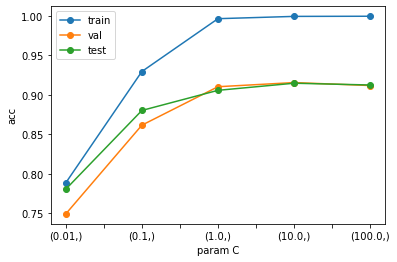

In [66]:
accuracy_accumulator.T.plot(marker="o")
plt.xlabel("param C")
plt.ylabel("acc")

#### 59

In [17]:
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [25]:
param_LR=[1e-2,1e-1,1e+0,1e+1,1e+2]  # C
param_LSVC=[1e-2,1e-1,1e+0,1e+1,1e+2]  # C
# param_SVC=[1e-2,1e-1,1e+0,1e+1,1e+2]  # C
param_DTC=[5,10,15,20,25]  # max_depth
param_RFC=[25,50,100,200,400]  # n_estimators

In [26]:
# algo_name_list=["LinearSVC","SVC","DecisionTreeClassifier","RandomForestClassifier"]
algo_name_list=["LogisticRegression","LinearSVC","DecisionTreeClassifier","RandomForestClassifier"]
param_dict={"LogisticRegression":param_LR,
            "LinearSVC":param_LSVC,
           "SVC":param_SVC,
           "DecisionTreeClassifier":param_DTC,
           "RandomForestClassifier":param_RFC
          }

In [27]:
def model_build(algo_name,param):
    if algo_name=="LogisticRegression":
        clf=LogisticRegression(max_iter=200,C=param)
    elif algo_name=="LinearSVC":
        clf=LinearSVC(C=param)
#     elif algo_name=="SVC":
#         clf=SVC(C=param)
    elif algo_name=="DecisionTreeClassifier":
        clf=DecisionTreeClassifier(max_depth=param)
    elif algo_name=="RandomForestClassifier":
        clf=RandomForestClassifier(n_estimators=param)
    return clf

In [21]:
param_search_accumulator=pd.DataFrame(columns=["algo_name","param","val_acc","test_acc"])

In [22]:
for algo_name in algo_name_list:
    param_list=param_dict[algo_name]
    for param in param_list:
# param=param_list[0]

        clf=model_build(algo_name,param)
        clf.fit(X_train_feature, y_train)
        pred_train=clf.predict(X_train_feature)
        pred_val=clf.predict(X_val_feature)
        pred_test=clf.predict(X_test_feature)
        print(f"model_param: {algo_name}_{param}")
        print("val_acc: ",accuracy_score(y_val,pred_val))
        print("test_acc: ",accuracy_score(y_test,pred_test))
        res=[algo_name,param,accuracy_score(y_val,pred_val),accuracy_score(y_test,pred_test)]
        res=pd.DataFrame([[algo_name,param,accuracy_score(y_val,pred_val),accuracy_score(y_test,pred_test)]],columns=["algo_name","param","val_acc","test_acc"])
        param_search_accumulator=pd.concat([param_search_accumulator,res],axis=0)
        param_search_accumulator.to_csv("param_search_accumulator.csv",index=None)

model_param: LinearSVC_0.01
val_acc:  0.8854790419161677
test_acc:  0.8734082397003745
model_param: LinearSVC_0.1
val_acc:  0.9176646706586826
test_acc:  0.9108614232209737
model_param: LinearSVC_1.0
val_acc:  0.9161676646706587
test_acc:  0.9093632958801499


C:\Users\USER\anaconda3\envs\Mecab\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


model_param: LinearSVC_10.0
val_acc:  0.9131736526946108
test_acc:  0.9063670411985019


C:\Users\USER\anaconda3\envs\Mecab\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


model_param: LinearSVC_100.0
val_acc:  0.905688622754491
test_acc:  0.8936329588014982
model_param: DecisionTreeClassifier_5
val_acc:  0.5591317365269461
test_acc:  0.5280898876404494
model_param: DecisionTreeClassifier_10
val_acc:  0.6040419161676647
test_acc:  0.5640449438202247
model_param: DecisionTreeClassifier_15
val_acc:  0.6601796407185628
test_acc:  0.6142322097378277
model_param: DecisionTreeClassifier_20
val_acc:  0.687125748502994
test_acc:  0.6449438202247191
model_param: DecisionTreeClassifier_25
val_acc:  0.7103293413173652
test_acc:  0.6719101123595506
model_param: RandomForestClassifier_25
val_acc:  0.8383233532934131
test_acc:  0.8224719101123595
model_param: RandomForestClassifier_50
val_acc:  0.8540419161676647
test_acc:  0.8389513108614233
model_param: RandomForestClassifier_100
val_acc:  0.8405688622754491
test_acc:  0.8352059925093633
model_param: RandomForestClassifier_200
val_acc:  0.8488023952095808
test_acc:  0.8419475655430712
model_param: RandomForestClassi

In [31]:
param_search_accumulator=pd.read_csv("param_search_accumulator.csv")

In [42]:
param_search_accumulator.sort_values("val_acc",ascending=False).iloc[:1]

,algo_name,param,val_acc,test_acc
6,LinearSVC,0.1,0.917665,0.910861
